# 7 AutoGen - Multi agents with image generation

The AutoGen ecosystem provides everything you need to create AI agents, especially multi-agent workflows -- framework, developer tools, and applications.

The framework uses a layered and extensible design. Layers have clearly divided responsibilities and build on top of layers below. This design enables you to use the framework at different levels of abstraction, from high-level APIs to low-level components.

Core API implements message passing, event-driven agents, and local and distributed runtime for flexibility and power. It also support cross-language support for .NET and Python.
AgentChat API implements a simpler but opinionated API for rapid prototyping. This API is built on top of the Core API and is closest to what users of v0.2 are familiar with and supports common multi-agent patterns such as two-agent chat or group chats.
Extensions API enables first- and third-party extensions continuously expanding framework capabilities. It support specific implementation of LLM clients (e.g., OpenAI, AzureOpenAI), and capabilities such as code execution.

<img src="https://github.com/microsoft/autogen/raw/main/autogen-landing.jpg" width=400>

> https://microsoft.github.io/autogen/stable/<br>
> https://github.com/microsoft/autogen

In [2]:
import autogen
import base64
import datetime
import matplotlib.pyplot as plt
import os
import sys

from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import TextMentionTermination, MaxMessageTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.auth.azure import AzureTokenProvider
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from azure.identity import DefaultAzureCredential
from dotenv import load_dotenv
from io import BytesIO
from openai import AzureOpenAI
from PIL import Image

## Settings

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 20-May-2025 14:37:29


In [3]:
load_dotenv("azure.env")

True

In [5]:
token_provider = AzureTokenProvider(
    DefaultAzureCredential(),
    "https://cognitiveservices.azure.com/.default",
)

In [6]:
client = AzureOpenAIChatCompletionClient(
    azure_deployment="gpt-4o-mini",
    model="gpt-4o-mini",
    api_version="2024-06-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_ad_token_provider=token_provider,
)

In [6]:
load_dotenv("azure.env")

api_version = "2025-04-01-preview"
model="gpt-image-1"

In [7]:
RESULTS_DIR = "results"

if os.path.exists(RESULTS_DIR):
    shutil.rmtree(RESULTS_DIR)

os.makedirs(RESULTS_DIR, exist_ok=True)

## Agents definition

In [8]:
mexican_chef = AssistantAgent( 
    name="mexican_chef", 
    model_client=client,
    system_message="You are a Mexican chef who is an expert in tacos, burritos, tortillas, and margaritas, and knows every recipe that is from Mexico.  You provide ideas about different dishes that can be offered, and you discuss with the Italian & French chef and the sommelier about which dish you prefer.", 

) 

italian_chef = AssistantAgent( 
    name="italian_chef", 
    model_client=client,
    system_message="You are a well-known Italian chef who is an expert in pizza, pasta, and gelato (ice cream), and knows every recipe that is italian focused. You provide ideas about different dishes that can be offered, and you discuss with the Mexican & French chef and the sommelier about which dish you prefer.", 
) 

french_chef = AssistantAgent( 
    name="french_chef", 
    model_client=client,
    system_message="You are a well-known French chef who is an expert in meat, fish and vegetables, and knows every recipe that is French focused. You provide ideas about different dishes that can be offered, and you discuss with the Mexican, Italian and the sommelier about which dish you prefer. ", 

) 

sommelier = AssistantAgent( 
    name="somellier", 
    model_client=client,
    system_message="You are a well-known somellier and expert in wines from every region in the world. You provide ideas about different wines that can be offered with the dishes, and you discuss with the Mexican, Italian and French chef about which wines you propose. Afterward, you both have to agree. If you have doubts about what to offer, look for information on the Internet. ", 

) 

## Example

In [9]:
query = "Generate a unique 5-course fusion menu from French, Italian and Mexican with appropriate wines for a summer event. Display the final menu in a mardown file"

In [10]:
max_msg_termination = MaxMessageTermination(max_messages=5)

In [11]:
group_chat = RoundRobinGroupChat(
    [mexican_chef, italian_chef, french_chef, sommelier], termination_condition=max_msg_termination
)

await Console(group_chat.run_stream(task=query))

await client.close()

---------- TextMessage (user) ----------
Generate a unique 5-course fusion menu from French, Italian and Mexican with appropriate wines for a summer event. Display the final menu in a mardown file
---------- TextMessage (mexican_chef) ----------
Certainly! Here’s a unique 5-course fusion menu that blends the flavors of French, Italian, and Mexican cuisines, perfect for a summer event. I've also paired each course with an appropriate wine.

```markdown
# Summer Fusion Menu

## Starter: Tacos de Cochon de Lait
**Description**: Crispy tortilla tacos filled with slow-roasted suckling pig, topped with fresh mango salsa and a drizzle of chipotle aioli.  
**Wine Pairing**: **Chenin Blanc** - This aromatic white wine will complement the richness of the pork and the freshness of the mango salsa.

---

## Second Course: Caprese Salad with Mole Poblano
**Description**: Fresh buffalo mozzarella and heirloom tomatoes drizzled with a rich mole poblano sauce and garnished with basil and cilantro.  
*

# Summer Fusion Menu

## Starter: Tacos de Cochon de Lait
**Description**: Crispy tortilla tacos filled with slow-roasted suckling pig, topped with fresh mango salsa and a drizzle of chipotle aioli.  
**Wine Pairing**: **Chenin Blanc** - Its fruity and floral notes perfectly complement the richness of the pork and the sweetness of the mango salsa.

---

## Second Course: Caprese Salad with Mole Poblano
**Description**: Fresh buffalo mozzarella paired with sun-ripened heirloom tomatoes, drizzled with rich mole poblano, and garnished with fragrant basil and cilantro.  
**Wine Pairing**: **Sauvignon Blanc** - The acidity and citrus notes of this wine cut through the richness of the mole, enhancing the freshness of the salad.

---

## Main Course: Coq au Vin Enchiladas
**Description**: Enchiladas filled with chicken braised in a classic French coq au vin sauce, topped with sour cream, and served alongside elote (Mexican street corn).  
**Wine Pairing**: **Pinot Noir** - A light-bodied Pinot Noir complements the savory chicken and balances the creaminess of the dish.

---

## Cheese Course: Queso Fundido with Brie
**Description**: A delicious blend of gooey brie and Mexican Chihuahua cheese, served warm with homemade tortilla chips and jalapeño slices for added heat.  
**Wine Pairing**: **Chardonnay** - A lightly oaked Chardonnay enhances the creaminess of the cheese while balancing the spice from the jalapeños.

---

## Dessert: Tarta de Tres Leches avec Framboises
**Description**: A luscious three milk cake layered with fresh raspberries, drizzled with raspberry coulis, and topped with a dollop of light whipped cream.  
**Wine Pairing**: **Moscato d'Asti** - This sweet, slightly sparkling wine pairs wonderfully with the cake's richness and the tartness of the raspberries.

---

**Bon appétit! Enjoy your summer fusion feast!**
```

## Images generation for the menu

In [12]:
def image_generation(prompt, n=1):
    """
    Generates images using Azure OpenAI's gpt-image-1 model.

    Parameters:
        prompt (str): The text prompt to generate images from.
        n (int, optional): The number of images to generate. Defaults to 1.

    Returns:
        list[str] or None: A list of file paths to the saved images if successful, or None if an error occurs.

    The function:
        - Connects to Azure OpenAI using credentials from environment variables.
        - Sends the prompt to the image generation model with specified parameters.
        - Decodes and displays each image.
        - Saves each image to a local results directory with a sanitized filename.
        - Returns a list of saved file paths.
    """
    try:
        # Client
        client = AzureOpenAI(
            azure_endpoint=os.getenv("gptimage_endpoint"),
            api_key=os.getenv("gptimage_key"),
            api_version=api_version,
        )

        # Paramaters
        params = {
            "model": model,  # Model
            "prompt": prompt,  # Prompt
            "n": n,  # Number of generated images
            "quality": "high",  # Options: high, medium, low
            "size": "1024x1024",  # Options: 1024x1024, 1536x1024, 1024x1536
        }
        # Results
        result = client.images.generate(**params)
        images_data = result.model_dump().get("data", [])
        encoded_images = [
            img.get("b64_json") for img in images_data if "b64_json" in img
        ]

        # Parsing the generated images
        output_images_list = []

        for encoded_image in encoded_images:
            img = Image.open(BytesIO(base64.b64decode(encoded_image)))
            # Saving image to a file
            now = str(datetime.datetime.today().strftime("%Y%m%d_%H%M%S_%f")[:-3])
            output_file = os.path.join(RESULTS_DIR, f"generated_image_{now}.jpg")
            img.save(output_file)
            print(f"File saved: {output_file}")
            output_images_list.append(output_file)

        return output_images_list

    except Exception as e:
        print(f"Error generating images: {e}")
        return None

In [13]:
prompt = """
Crispy tortilla tacos filled with slow-roasted suckling pig, topped with fresh mango salsa and a drizzle of chipotle aioli.  
Wine Pairing: Chenin Blanc - Its fruity and floral notes perfectly complement the richness of the pork and the sweetness of the mango salsa.
"""

In [14]:
images_list = image_generation(prompt, 1)

File saved: results/generated_image_20250520_144012_764.jpg


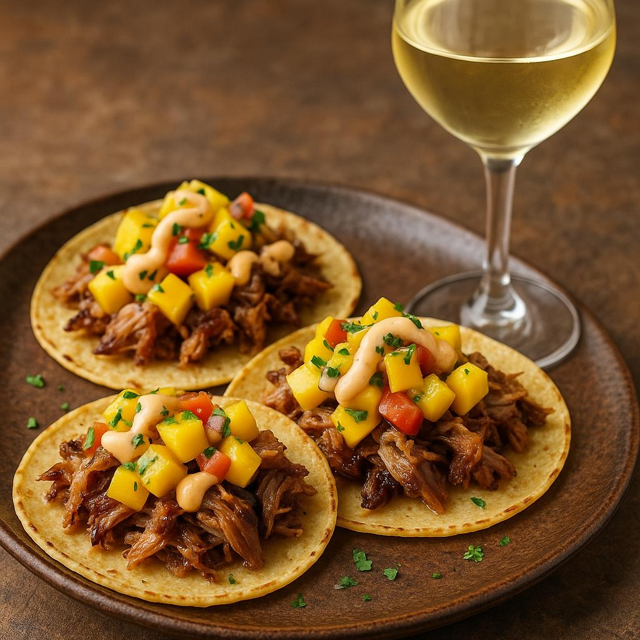

In [15]:
img = Image.open(images_list[0])
img.resize((640,640))

In [16]:
prompt = """
**Description**: Fresh buffalo mozzarella paired with sun-ripened heirloom tomatoes, drizzled with rich mole poblano, and garnished with fragrant basil and cilantro.  
**Wine Pairing**: **Sauvignon Blanc** - The acidity and citrus notes of this wine cut through the richness of the mole, enhancing the freshness of the salad.
"""

In [17]:
images_list = image_generation(prompt, 1)

File saved: results/generated_image_20250520_144125_677.jpg


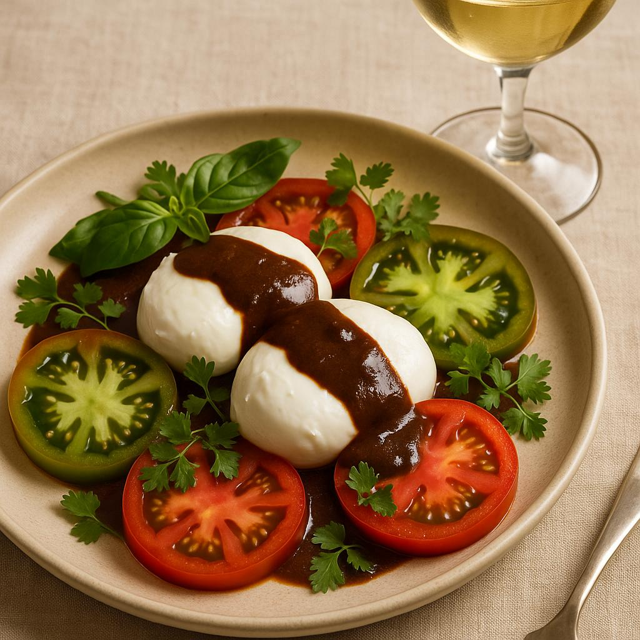

In [18]:
img = Image.open(images_list[0])
img.resize((640,640))

In [19]:
prompt = """ 
**Description**: Enchiladas filled with chicken braised in a classic French coq au vin sauce, topped with sour cream, and served alongside elote (Mexican street corn).  
**Wine Pairing**: **Pinot Noir** - A light-bodied Pinot Noir complements the savory chicken and balances the creaminess of the dish.
"""

In [20]:
images_list = image_generation(prompt, 1)

File saved: results/generated_image_20250520_144213_022.jpg


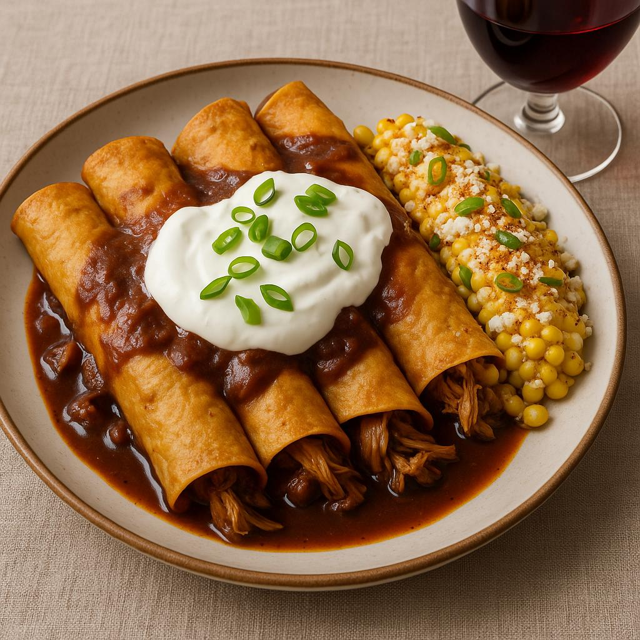

In [21]:
img = Image.open(images_list[0])
img.resize((640,640))

In [22]:
prompt = """
**Description**: A delicious blend of gooey brie and Mexican Chihuahua cheese, served warm with homemade tortilla chips and jalapeño slices for added heat.  
**Wine Pairing**: **Chardonnay** - A lightly oaked Chardonnay enhances the creaminess of the cheese while balancing the spice from the jalapeños.
"""

In [23]:
images_list = image_generation(prompt, 1)

File saved: results/generated_image_20250520_144300_625.jpg


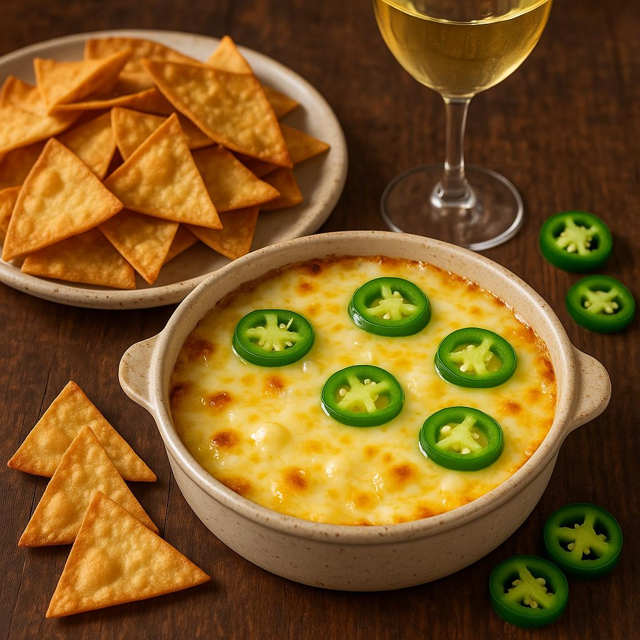

In [24]:
img = Image.open(images_list[0])
img.resize((640,640))

In [25]:
prompt = """
**Description**: A luscious three milk cake layered with fresh raspberries, drizzled with raspberry coulis, and topped with a dollop of light whipped cream.  
**Wine Pairing**: **Moscato d'Asti** - This sweet, slightly sparkling wine pairs wonderfully with the cake's richness and the tartness of the raspberries.
"""

In [26]:
images_list = image_generation(prompt, 1)

File saved: results/generated_image_20250520_144347_816.jpg


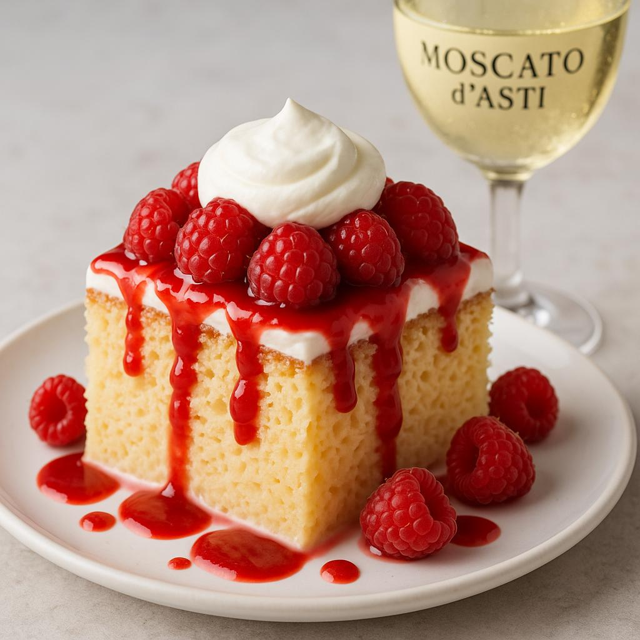

In [27]:
img = Image.open(images_list[0])
img.resize((640,640))

### All generated images

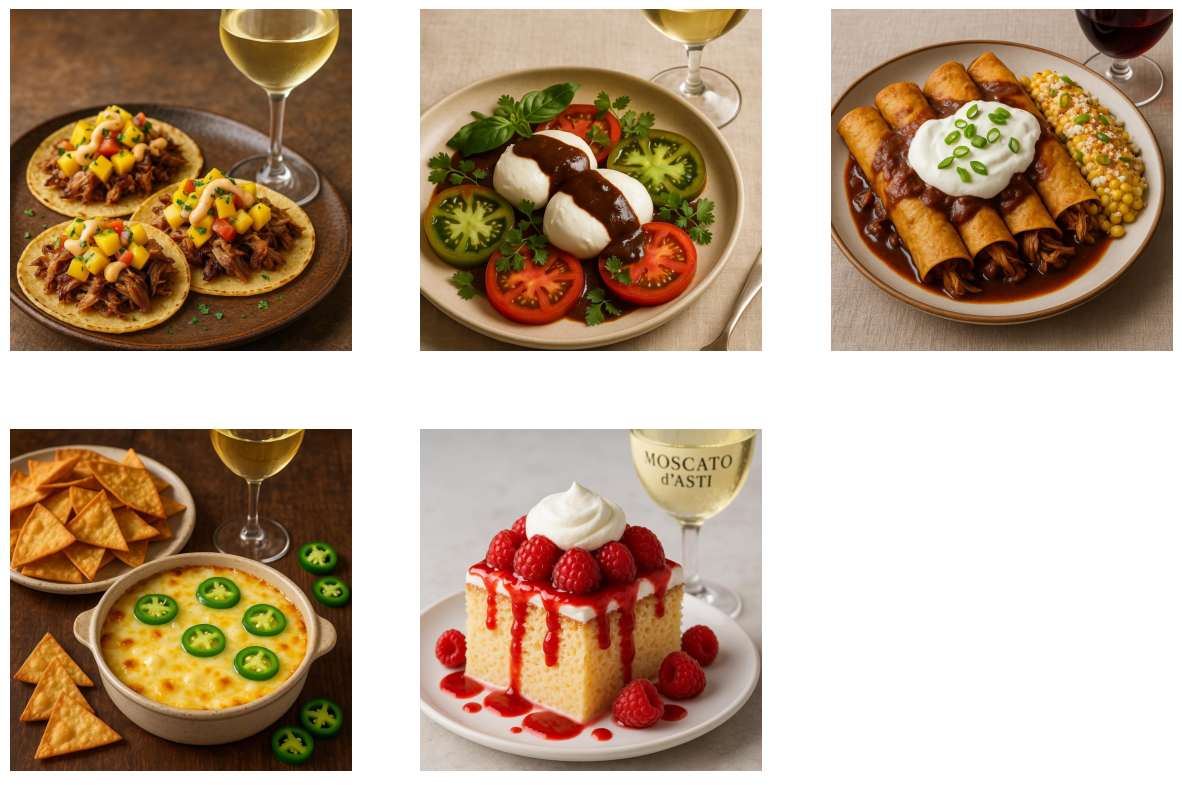

In [28]:
images = []

for filename in os.listdir(RESULTS_DIR):
    if filename.endswith('.jpg'):
        img = Image.open(os.path.join(RESULTS_DIR, filename))
        images.append(img)

images_per_row = 3
num_rows = (len(images) + images_per_row - 1) // images_per_row
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()